# The standard incomplete markets model: steady state

NBER Heterogeneous-Agent Macro Workshop

Matthew Rognlie

Spring 2023

# Standard incomplete markets model
- Come in with assets including return $(1+r)a$ and stochastic income $y(e)$
- Allocate to assets for tomorrow $a'$ and consumption today $c$
- ... all subject to a borrowing constraint $a'\geq \underline{a}$ and no ability to insure against the shock $e$


$$
\begin{gather}
V(e,a)=\max_{c,a'} u(c)+\beta\mathbb{E}[V(e',a')|e] \tag{1}\\
\text{s.t. }a'+c=(1+r)a+y(e) \tag{2}\\
a'\geq \underline{a} \tag{3} \\
\end{gather}
$$

- (aka Bewley-Huggett-Aiyagari-Imrohoroglu-Zeldes-Deaton-Carroll model)

# Nice features of this model
- Simple way to think about consumption-saving problem given risk (income smoothing, precautionary savings, etc.)


- Consistent with high marginal propensities to consume (MPCs) out of unanticipated one-time shocks, in line with data (**crucial** for us!)

- The level of MPC in the data is around 0.04 for US and 0.02 for European countries?


- Endogenously generates wealth distribution (and inequality)


- Unlike representative-agent model, steady-state asset demand not infinitely elastic in $r$


- Easy to extend
    * other shocks, preference heterogeneity, endogenous labor, life-cycle structure, other assets...
    
    
- **Backbone of everything we'll do!**

# Solving the model in steady state
Four steps, middle two the hardest:

1. **Discretizing state space**: get Markov chain for $e$ and grid for $a$


2. **Solving for steady-state policy function**: get policies $a'(e,a)$ and $c(e,a)$ on grid


3. **Solving for steady-state distribution**: get discretized distribution $D(e,a)$ of agents on grid


4. **Aggregating**: combine steps 2 and 3 to get aggregate assets and consumption

# Preliminaries
Before we start, we need to import the Python libraries that we'll be using:

In [54]:
import numpy as np
import numba
from scipy import optimize
import matplotlib.pyplot as plt

# some useful plot defaults
plt.rcParams.update({'font.size' : 20, 'lines.linewidth' : 3.5, 'figure.figsize' : (13,7)})

# Part 1 of computation: discretizing state space

# Part 1A: discretizing the asset space
- In theory, households pick assets from $[\underline{a},\infty)$, need to discretize into a grid


- Will use linear interpolation on policy function, so we want **more gridpoints where policy function is more nonlinear in assets**
    * This turns out to be near $\underline{a}$
    
    
- But also want grid going up to very high level of assets, to capture wealthiest


- Solution: **double-exponential transformation** of a uniformly spaced grid


- Start with uniformly spaced points $u_i$ on an interval $[0,\bar{u}]$, construct gridpoints $a_i$

$$
a_i = \underline{a} + e^{e^{u_i}-1}-1 \tag{4}
$$

# Discretizing asset space continued
Uniform points $u_i$ on $[0,\bar{u}]$, construct $a_i$ as

$$
a_i = \underline{a} + e^{e^{u_i}-1}-1 \tag{4}
$$

This gives min of $\underline{a}$, max of $e^{e^{\bar{u}}-1}-1$. Equating this max with $\overline{a}$ gives

$$
\bar{u} = \log(1+\log(1+ \overline{a} - \underline{a}))
$$

Implement in function below:

In [3]:
def discretize_assets(amin, amax, n_a):
    # find maximum ubar of uniform grid corresponding to desired maximum amax of asset grid
    ubar = np.log(1 + np.log(1 + amax - amin))
    
    # make uniform grid
    u_grid = np.linspace(0, ubar, n_a)
    
    # double-exponentiate uniform grid and add amin to get grid from amin to amax
    return amin + np.exp(np.exp(u_grid) - 1) - 1

# Visualizing results
Example of 50 points between 0 and 10,000. (Normally we want more than this, but easier to visualize.)

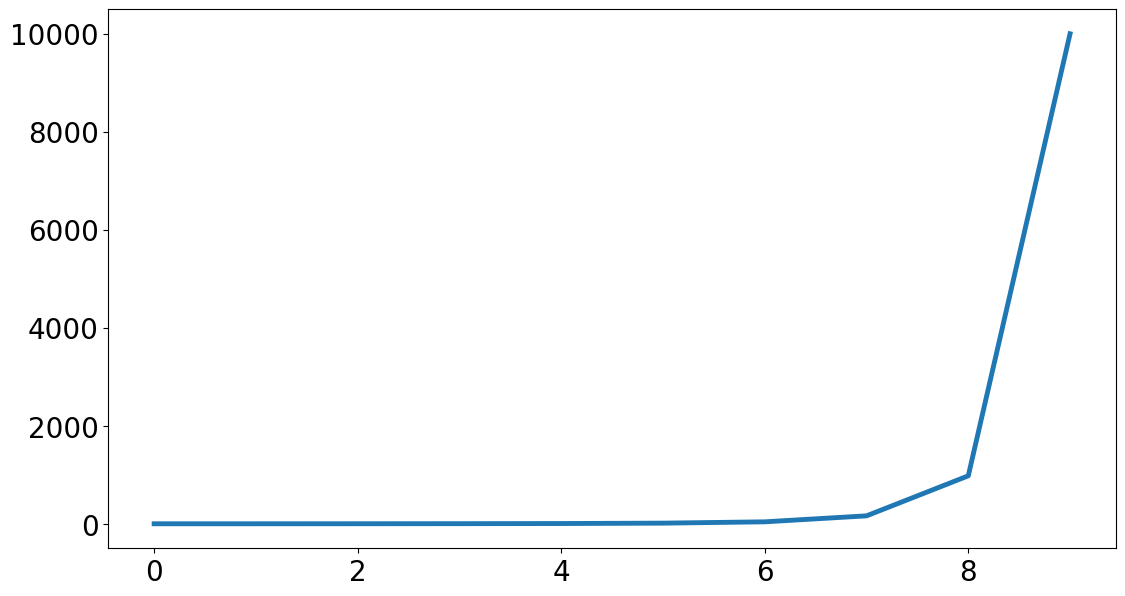

In [4]:
a_grid = discretize_assets(0, 10_000, 10)
plt.plot(a_grid)
plt.show()

Note vastly greater concentration near the borrowing constraint of 0: out of 50, first 12 points are less than 1, next 10 points are less than 5

Many variations on this (e.g. could add scalar parameters to double exponential, or try triple exponential as suggested by Carroll)

# Part 1B: discretizing incomes
- We had arbitrary Markov process $e$ and mapping to incomes $y(e)$


- Lots of possible choices: could have two states for employed vs. unemployed, etc.


- Simplest case: assume $\log y_t$ follows an AR(1) process with some persistence $\rho$ and normal innovations $\epsilon_t$

$$
\log y_t = \rho \log y_{t-1} + \epsilon_t \tag{5}
$$

- Try to approximate (5) with $n$ discrete states


- We'll use **Rouwenhorst** method for discretization ([see Kopecky and Suen](http://www.karenkopecky.net/Rouwenhorst_WP.pdf)).
    - Also popular but worse for common case of $\rho$ close to 1: [Tauchen (1986) method](https://doi.org/10.1016/0165-1765(86)90168-0)
    
    
- **Basis for Rouwenhorst method**: models sum $e$ of $n-1$ independent hidden binary states (can be 0 or 1), each of which have probability $p$ of staying at current value, $1-p$ of switching


- $n$ possible values of this sum, from 0 to $n-1$; as $n$ gets higher, sum $e$ behaves more and more like AR(1) with normal innovations

# Getting Markov matrix (for completeness, won't cover in detail)
Can show that the Markov transition matrix $\Pi^n$ over values of $e$ obeys the recursion

$$
\tilde{\Pi}^{n}=p\begin{bmatrix}\Pi^{n-1} & \mathbf{0}\\
\mathbf{0}' & 0
\end{bmatrix}+(1-p)\begin{bmatrix}\mathbf{0} & \Pi^{n-1}\\
0 & \mathbf{0}'
\end{bmatrix}+(1-p)\begin{bmatrix}\mathbf{0}' & 0\\
\Pi^{n-1} & \mathbf{0}
\end{bmatrix}+p\begin{bmatrix}0 & \mathbf{0}'\\
\mathbf{0} & \Pi^{n-1}
\end{bmatrix} \tag{6}
$$

and $\Pi^n$ equal to $\tilde{\Pi}^{n}$ in first and last rows and $\tilde{\Pi}^{n}/2$ in other rows, with base case:

$$
\Pi^{2}=\begin{bmatrix}p & 1-p\\
1-p & p
\end{bmatrix} \tag{7}
$$

Implement in this function:

In [5]:
def rouwenhorst_Pi(N, p):
    # base case Pi_2
    Pi = np.array([[p, 1 - p],
                   [1 - p, p]])
    
    # recursion to build up from Pi_2 to Pi_N
    for n in range(3, N + 1):
        Pi_old = Pi
        Pi = np.zeros((n, n))
        
        Pi[:-1, :-1] += p * Pi_old
        Pi[:-1, 1:] += (1 - p) * Pi_old
        Pi[1:, :-1] += (1 - p) * Pi_old
        Pi[1:, 1:] += p * Pi_old
        Pi[1:-1, :] /= 2
        
    return Pi

# Using this to match an AR(1)

- Drawing a random sequence $e_t$ using $\Pi_n$, one can show "persistence" $\rho$ from regressing $e_t$ on $e_{t-1}$ is $2p-1$, so to match desired persistence $\rho$ set

$$
p = \frac{1+\rho}{2}
$$

- $e_t$ is sum of $n-1$ independent states with 50-50 probability of being 0 or 1, so its stationary distribution is the [binomial distribution](https://en.wikipedia.org/wiki/Binomial_distribution) with $n-1$ trials and success probability 1/2, which has standard deviation $\sigma = \sqrt{n-1}/2$


- So to match desired cross-sectional standard deviation of log income, scale $e_t$ by constant

$$
\alpha \equiv \frac{2 \sigma}{\sqrt{n-1}}
$$


- Could add $C$ constant to $e_t$, but this will scale income by $\exp(C)$, we'll pick scaling factor directly to normalize income

# Technical preliminary: find stationary distribution of Markov chain
Given transition matrix $\Pi$, simple and robust way to find stationary distribution is to repeatedly apply transition matrix, updating distribution $\pi$ to $\Pi'\pi$, until convergence up to some tolerance:

In [6]:
def stationary_markov(Pi, tol=1E-14):
    # start with uniform distribution over all states
    n = Pi.shape[0]
    pi = np.full(n, 1/n)
    
    # update distribution using Pi until successive iterations differ by less than tol
    for _ in range(10_000):
        pi_new = Pi.T @ pi
        if np.max(np.abs(pi_new - pi)) < tol:
            return pi_new
        pi = pi_new

# Now use our insights to obtain discretized income process
Given a target for persistence $\rho$, cross-sectional standard deviation $\sigma$, and the number of discrete states $n_e$, this function gives us the $y(e)$ for each state $e=0,\ldots,n_e-1$ (normalized to have mean of 1), the stationary distribution $\pi(e)$ over states, and Markov transition matrix $\Pi(e,e')$ between states.

In [7]:
def discretize_income(rho, sigma, n_e):
    # choose inner-switching probability p to match persistence rho
    p = (1+rho)/2
    
    # start with states from 0 to n_e-1, scale by alpha to match standard deviation sigma
    e = np.arange(n_e)
    alpha = 2*sigma/np.sqrt(n_e-1)
    e = alpha*e
    
    # obtain Markov transition matrix Pi and its stationary distribution
    Pi = rouwenhorst_Pi(n_e, p)
    pi = stationary_markov(Pi)
    
    # e is log income, get income y and scale so that mean is 1
    y = np.exp(e)
    y /= np.vdot(pi, y)
    
    return y, pi, Pi

# Example
Let's try $\rho=0.975$, $\sigma=0.7$, and $n_e=7$. The former two values roughly match some estimates of the quarterly persistence, and the standard deviation, of the persistent component of log income in the US.

In [8]:
y, pi, Pi = discretize_income(0.975, 0.7, 7)
print("y:" , y)
print("transition matrix:\n", Pi)

y: [0.1413694  0.25036602 0.44339966 0.78526334 1.3907059  2.46294815
 4.36189534]
transition matrix:
 [[9.27305052e-01 7.04282318e-02 2.22874151e-03 3.76158905e-05
  3.57112885e-07 1.80816650e-09 3.81469727e-12]
 [1.17380386e-02 9.28047966e-01 5.87090011e-02 1.48606575e-03
  1.88094521e-05 1.19041443e-07 3.01361084e-10]
 [1.48582767e-04 2.34836004e-02 9.28493857e-01 4.69747253e-02
  8.91687069e-04 7.52378082e-06 2.38075256e-08]
 [1.88079453e-06 4.45819725e-04 3.52310439e-02 9.28642511e-01
  3.52310439e-02 4.45819725e-04 1.88079453e-06]
 [2.38075256e-08 7.52378082e-06 8.91687069e-04 4.69747253e-02
  9.28493857e-01 2.34836004e-02 1.48582767e-04]
 [3.01361084e-10 1.19041443e-07 1.88094521e-05 1.48606575e-03
  5.87090011e-02 9.28047966e-01 1.17380386e-02]
 [3.81469727e-12 1.80816650e-09 3.57112885e-07 3.76158905e-05
  2.22874151e-03 7.04282318e-02 9.27305052e-01]]


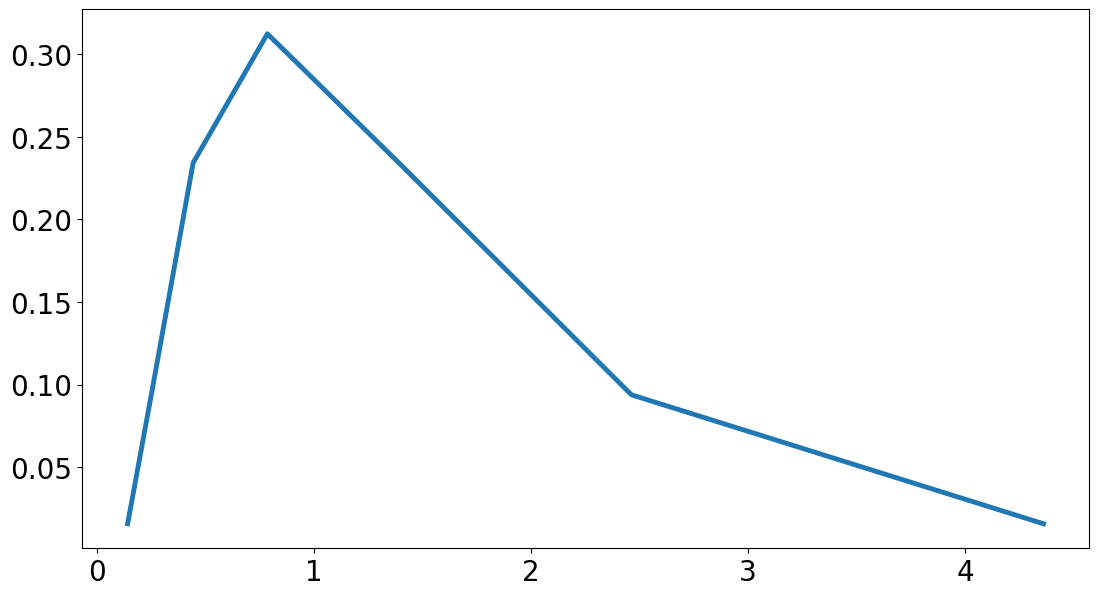

In [9]:
plt.plot(y, pi)
plt.show()

Verify mean of $y$ is 1 as desired:

In [10]:
np.vdot(pi, y)

0.9999999999999999

Verify standard deviation is $\sigma=0.7$:

In [11]:
mean_log_y = np.vdot(pi, np.log(y))
sd_log_y = np.sqrt(np.vdot(pi, (np.log(y) - mean_log_y)**2))
sd_log_y

0.7000000000003476

# Part 2 of computation: backward iteration to obtain the policy function
Back to standard incomplete markets model, with $t$ subscripts added:

$$
\begin{gather}
V_t(e,a)=\max_{c,a'} u(c)+\beta\mathbb{E}[V_{t+1}(e',a')|e] \tag{1}\\
\text{s.t. }a'+c=(1+r_t)a+y_t(e) \tag{2}\\
a'\geq \underline{a} \tag{3} \\
\end{gather}
$$

Optimal policy characterized by two conditions, which only require derivative of value function $V_a$ with respect to assets ("marginal value function"), not value function itself.

**Envelope condition**:
$$
V_{a,t}(e,a)=(1+r_t)u'(c_t(e,a)) \tag{8}
$$

**First-order condition** (inequality binds unless borrowing constraint binds):

$$
u'(c_t(e,a)) \geq \beta \mathbb{E}[V_{a,t+1}(e',a_t'(e,a))|e] \tag{9}
$$

More efficient and accurate to use (8) and (9) to iterate directly on $V_a$ than to do standard value function iteration ([Carroll 2006, "endogenous gridpoints method"](https://doi.org/10.1016/j.econlet.2005.09.013))

Backward iteration in time: take tomorrow's $V_{a,t+1}$ on right in (9), solve for today's policies $a_t'(e,a)$ and $c_t(e,a)$ and marginal value function $V_{a,t}$

# Step 1: discounting and expectations
Define "end-of-period" value function $W_t$ as

$$
W_t(e,a') \equiv \beta \mathbb{E}[V_{t+1}(e',a')|e] \tag{10}
$$

so that (9) simplifies to

$$
u'(c_t(e,a)) \geq W_{a,t}(e,a_t'(e,a)) \tag{11}
$$

Take expectations in (10) by multiplying by Markov matrix $\Pi$, so if $V_{a,t+1}(e,a)$ is in $n_e\times n_a$ array `Va`, get $n_e\times n_a$ array `Wa` of $W_{a,t}$ by writing

```Python
Wa = (beta * Pi) @ Va
```

# Step 2: solving for asset policy using first-order condition (hardest!)
- Simplified first-order condition using $W_t$:

$$u'(c_t(e,a)) \geq W_{a,t}(e,a_t'(e,a)) \tag{11}$$

- Assume for now this holds with equality, and define $a_t(e,a')$ to be inverse of $a_t'(e,a)$, i.e. $a_t(e,a_t'(e,a))\equiv a$, so (11) can be rewritten as

$$
c_t(e,a_t(e,a')) = \underbrace{(u')^{-1}(W_{a,t}(e,a'))}_{\equiv c_t^{endog}(e,a')} \tag{12}
$$

- This is time-$t$ consumption at the so-called **endogenous gridpoint** $(e,a_t(e,a'))$, which is at whatever asset level today that makes the household choose assets $a'$ tomorrow


- This must obey budget constraint, where we define **cash on hand** to be $coh_t(e,a)\equiv (1+r_t)a + y_t(e)$:

$$
c_t^{endog}(e,a')+a' = coh_t(e,a(e,a')) \tag{13}
$$

- Calculating  $c_t^{endog}$ and $coh_t$ in code, making the additional assumption that the utility function is isoelastic, i.e. $u(c) \equiv \frac{c^{1-\sigma^{-1}}}{1-\sigma^{-1}}$, with elasticity of intertemporal substitution $\sigma$ (`eis` in the code), so that $(u')^{-1}(x) = x^{-\sigma}$:
```Python
c_endog = Wa**(-eis)
coh = y[:, np.newaxis] + (1+r)*a_grid
```


# Step 2, continued
- Take budget constraint (2)

$$
c_t^{endog}(e,a')+a' = coh_t(e,a(e,a')) = (1+r_t)a_t(e,a') + y_t(e) \tag{13}
$$

- *Could* isolate $a_t(e,a')$ by writing

$$
a_t(e,a') = \frac{c_t^{endog}(e,a') + a' - y_t(e)}{1+r_t}
$$

- Ultimately, though, we want the inverse (holding $e$ fixed) of this function, $a_t'(e,a)$, defined on our regular grid


- Given $a_t(e,a')$, the easiest way to get that inverse is to evaluate $(a_t(e,a'),a')$ on the grid of all $a'$ for a given $e$, treating these as *sample points* from the function $a_t'(e,a)$, and then to *linearly interpolate* to evaluate $a_t'(e,a)$ on our grid of $a$


- Turns out an *equivalent* (thanks to linearity) and slightly more convenient alternative is to think of (13) as giving a collection of sample points $(coh(e,a_t(e,a')), a')$ from the function mapping cash on hand to asset choice $a'$, then linearly interpolate to evaluate $a'$ for cash-on-hand $coh_t(e,a)$ on the actual grid of $a$, giving us $a_t'(e,a)$ on our grid of $a$

- Need to do this separately for each $e$, so code iterates over them:

```Python
a = np.empty_like(coh)
for e in range(len(y)):
    a[e, :] = np.interp(coh[e, :], c_endog[e, :] + a_grid, a_grid)
```

# Step 3: enforcing the borrowing constraint and backing out consumption
- We just obtained policy function $a_t'(e,a)$ assuming Euler equation (11) held with equality, ignoring borrowing constraint $a'\geq \underline{a}$


- Simple to fix: if $a_t'(e,a)$ we calculated is below $\underline{a}$, then (11) doesn't hold with equality after all, and instead constraint binds so $a_t'(e,a)=\underline{a}$


- Hence, we should replace $a_t'(e,a)$ with $\max(a_t'(e,a),\underline{a})$


- Then back out consumption from budget constraint (2), as whatever is left over from cash on hand after we choose assets: $c_t(e,a) = coh_t(e,a) - a_t'(e,a)$


- Implementing in code (assuming first point on grid is $\underline{a}$):

```Python
a = np.maximum(a, a_grid[0])
c = coh - a
```

# Step 4: use envelope condition to recover derivative of value function
Implement envelope condition (8), again using parametrization of $u$ where $u'(c)=c^{-1/\sigma}$, and $\sigma$ is `eis` in code:

```Python
Va = (1+r) * c**(-1/eis)
```

# Combining everything into a single backward iteration
Combine the 9 lines of code we wrote for steps 1 to 4 into the body of a single backward iteration function

In [12]:
def backward_iteration(Va, Pi, a_grid, y, r, beta, eis):
    # step 1: discounting and expectations
    Wa = (beta * Pi) @ Va
    
    # step 2: solving for asset policy using the first-order condition
    c_endog = Wa**(-eis)
    coh = y[:, np.newaxis] + (1+r)*a_grid
    
    a = np.empty_like(coh)
    for e in range(len(y)):
        a[e, :] = np.interp(coh[e, :], c_endog[e, :] + a_grid, a_grid)
        
    # step 3: enforcing the borrowing constraint and backing out consumption
    a = np.maximum(a, a_grid[0])
    c = np.maximum(coh - a, 1E-9)
    
    # step 4: using the envelope condition to recover the derivative of the value function
    Va = (1+r) * c**(-1/eis)
    
    return Va, a, c

This function takes in an $n_e\times n_a$ array `Va` containing tomorrow's marginal value function $V_{a,t+1}$ at every point on the grid. It also takes in the $n_e\times n_e$ Markov matrix `Pi` ($\Pi$), the length-$n_a$ asset grid `a`, the length-$n_e$ array `y` of incomes $y_t(e)$, and the scalars `r` ($r_t$), `beta` ($\beta$), and `eis` ($\sigma$).

It outputs $n_e\times n_a$ arrays containing today's marginal value function $V_{a,t}$ and the policies $a'_t$ and $c_t$ at every point on the grid.

# Obtaining steady-state policies
To obtain steady-state $V_a$ and policies $a'$ and $c$, we need:
- Initial guess for steady-state $V_a$
- Iterate backward using `backward_iteration` until convergence criterion hit

For now we try:
- $c$ equals 5% of cash-on-hand, use envelope condition to turn into guess for $V_a$
- terminate backward iteration once the max distance between the asset policy function on two successive iterations falls below some tolerance, say $10^{-9}$
    * (also max number of iterations, say 10,000, as a fail-safe so that the computer doesn't run forever if it isn't converging)

In [13]:
def policy_ss(Pi, a_grid, y, r, beta, eis, tol=1E-9):
    # initial guess for Va: assume consumption 5% of cash-on-hand,
    # then get Va from envelope condition
    coh = y[:, np.newaxis] + (1+r)*a_grid
    c = np.maximum(0.05*coh, 1E-9)
    Va = (1+r) * c**(-1/eis)
    
    # iterate until maximum distance between two iterations
    # falls below tol, fail-safe max of 10,000 iterations
    for it in range(10_000):
        Va, a, c = backward_iteration(Va, Pi, a_grid, y, r, beta, eis)
        
        # after iteration 0, can compare new policy function to old one
        if it > 0 and np.max(np.abs(a - a_old)) < tol:
            return Va, a, c
        
        a_old = a

# Calibrated example
Make grids for assets and income, with 500 points and 7 points respectively, and a borrowing constraint of 0. Use same calibration for income as we did above:

In [14]:
a_grid = discretize_assets(0, 10_000, 500)
y, pi, Pi = discretize_income(0.975, 0.7, 7)

Choose some values for the other parameters, with the idea that this is a quarterly calibration:

In [15]:
r = 0.01/4
beta = 1-0.08/4
eis = 1

Solve for steady-state policies:

In [16]:
Va, a, c = policy_ss(Pi, a_grid, y, r, beta, eis)

# Visualizing consumption policy function
Looking at entire function, it seems linear, because at high assets it becomes asymptotically linear, and our grid includes really high asset levels to make sure we don't miss any rich households:

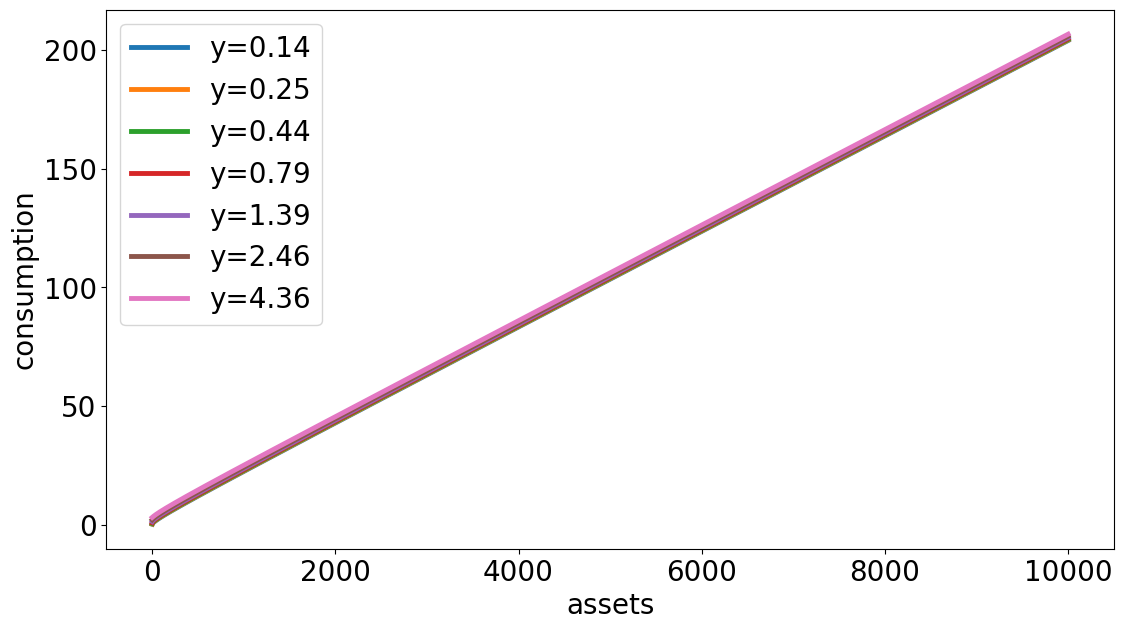

In [17]:
for e, ye in enumerate(y):
    plt.plot(a_grid, c[e, :], label=f'y={ye:.2f}')
plt.legend()
plt.xlabel('assets')
plt.ylabel('consumption');

# Visualizing consumption policy function, continued
Looking only at lower assets, we see a more interesting picture, with some of the well-known *concavity* of the consumption function for lower income states:

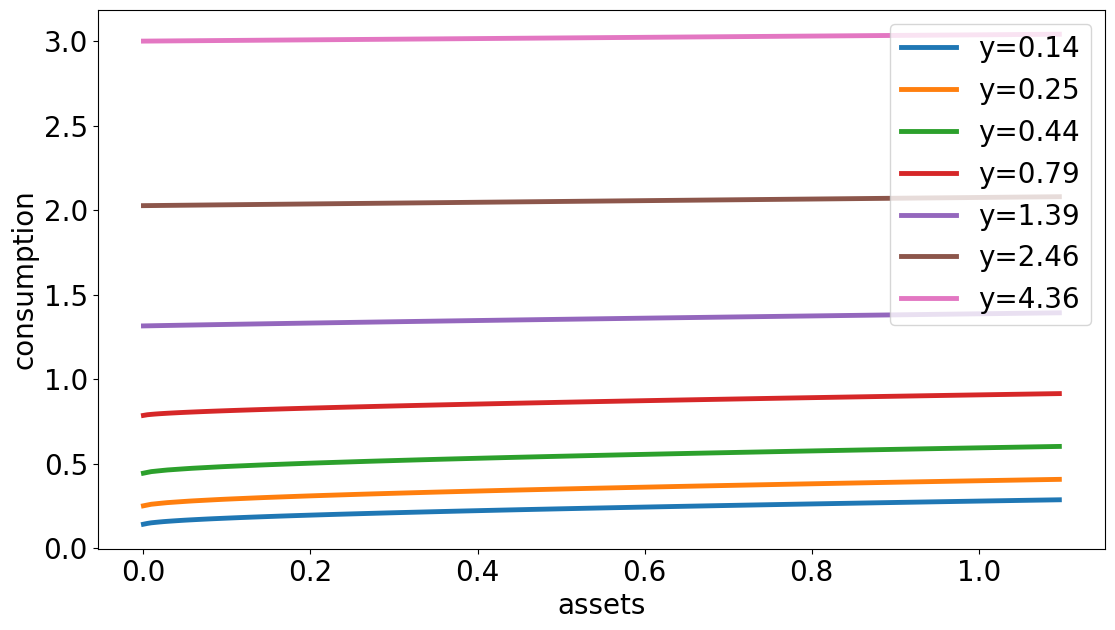

In [18]:
for e, ye in enumerate(y):
    plt.plot(a_grid[:120], c[e, :120], label=f'y={ye:.2f}')
plt.legend()
plt.xlabel('assets')
plt.ylabel('consumption');

# Visualizing consumption policy function, continued
It's even more visible if we zoom in on only the lowest income states:

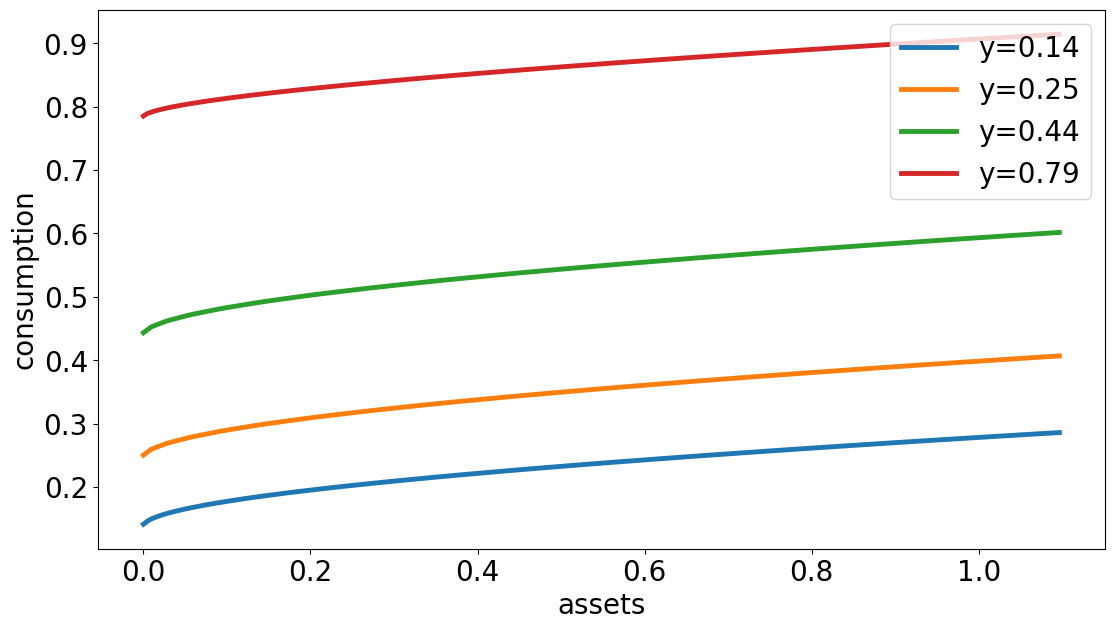

In [19]:
for e, ye in enumerate(y[:4]):
    plt.plot(a_grid[:120], c[e, :120], label=f'y={ye:.2f}')
plt.legend()
plt.xlabel('assets')
plt.ylabel('consumption');

# Visualizing consumption policy function, continued
It's also interesting to plot net saving—the increase or decrease in assets. For each income state, there is a "target" level of assets where net saving is zero. For lower incomes, this is zero (the borrowing constraint). For higher incomes, people are net savers until they reach a very high level of assets. You can see how this might produce a right-skewed distribution of assets!

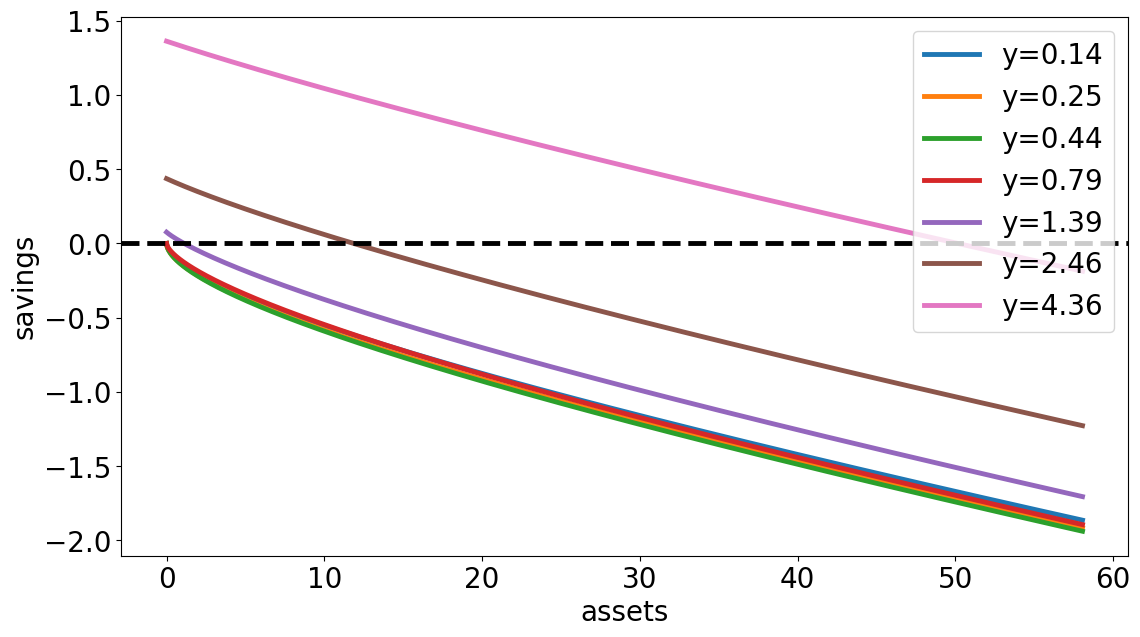

In [20]:
for e, ye in enumerate(y):
    plt.plot(a_grid[:350], a[e, :350] - a_grid[:350], label=f'y={ye:.2f}')
plt.axhline(0, linestyle='--', color='k')
plt.legend()
plt.xlabel('assets')
plt.ylabel('savings');

# Marginal propensities to consume
Another important concept is the marginal propensity to consume (MPC) out of a one-time, unexpected increase in cash on hand. This equals the derivative of consumption function with respect to assets, divided by asset income $1+r$. 

Calculating it by taking differences of the consumption function to approximate the derivative:

In [21]:
mpcs = np.empty_like(c)
    
# symmetric differences away from boundaries
mpcs[:, 1:-1] = (c[:, 2:] - c[:, 0:-2]) / (a_grid[2:] - a_grid[:-2]) / (1+r)

# asymmetric first differences at boundaries
mpcs[:, 0]  = (c[:, 1] - c[:, 0]) / (a_grid[1] - a_grid[0]) / (1+r)
mpcs[:, -1] = (c[:, -1] - c[:, -2]) / (a_grid[-1] - a_grid[-2]) / (1+r)

# special case of constrained
mpcs[a == a_grid[0]] = 1

# Someone who wants to borrow fully, wants to consume more. Therefore,
# an increase in the COH would fully go to the consumption. In other words,
# MPC is equal to 1.

# Visualizing marginal propensities to consume
Since the consumption function is concave, MPCs are declining in assets.

We see here that it seems to jump downward, e.g. from 1 to around 0.5 as households go from constrained to "not constrained, but probably constrained tomorrow, so we'll smooth any resources at the margin between 2 periods". These stark jumps exist in discrete time as long as we have discretized income states.

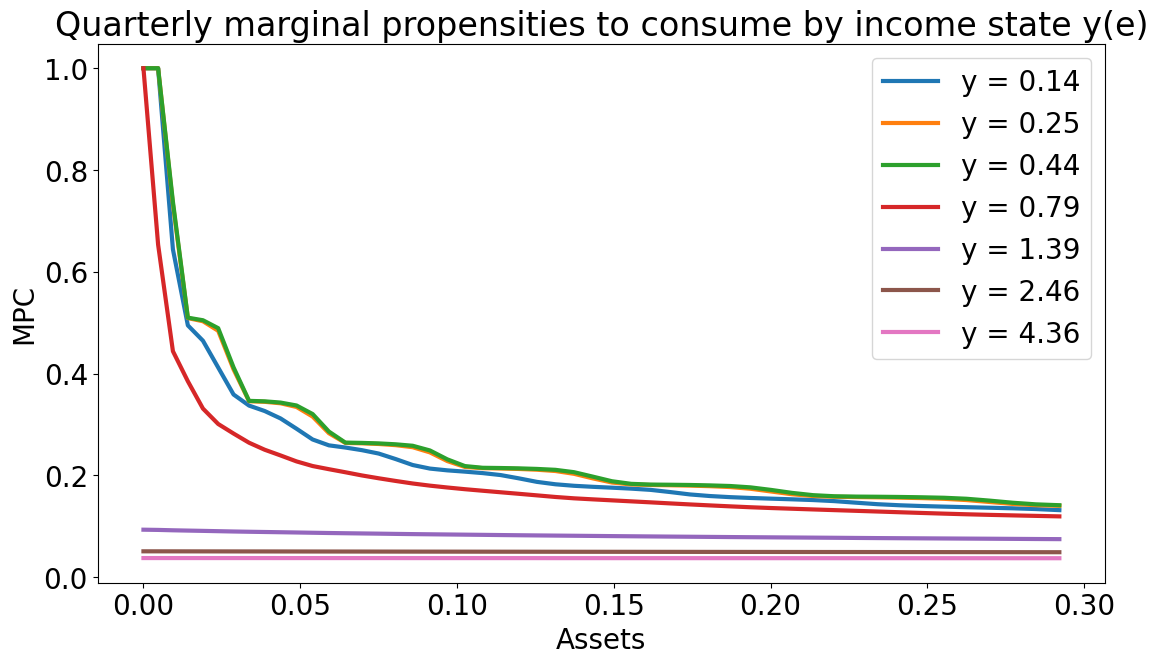

In [22]:
for e in range(7):
    plt.plot(a_grid[:50], mpcs[e, :50], linewidth=3, label=f'y = {y[e]:.2f}')
plt.xlabel('Assets')
plt.ylabel('MPC')
plt.title('Quarterly marginal propensities to consume by income state y(e)')
plt.legend();

# Part 3 of computation: forward iteration to obtain the distribution
- We'd like to obtain a discretized distribution giving the mass of agents at each point on our grid


- Problem: in general, if we start at a gridpoint, the asset policy function takes us off the grid


- For instance, look at asset policy for second-highest income state ($y = 2.46$) and assets of zero:

In [23]:
a[5, 0]

0.43644603651957736

This turns out to be in between points 66 and 67 on the grid:

In [24]:
a_grid[60:70]

array([0.38029038, 0.38883467, 0.3974721 , 0.40620394, 0.41503147,
       0.423956  , 0.43297886, 0.44210141, 0.45132502, 0.46065108])

Where should we assume this mass of households goes?

# Solution: lotteries
- Assume household follows a "lottery", going to each of the nearest two gridpoints with some probability, such that on average, the household chooses the right asset value


- We can think of this as a local first-order approximation


- In particular, let the asset grid be $(a_0,\ldots,a_{n_a-1})$. If some policy $a'$ lies in between gridpoints $a_i$ and $a_{i+1}$, then we want a lottery where the household goes to $a_i$ with probability $\pi$ and $a_{i+1}$ with probability $1-\pi$, such that

$$
\pi a_i + (1-\pi) a_{i+1} = a'
$$

- This can easily be solved to give

$$
\pi = (a_{i+1} - a')/(a_{i+1} - a_i) \tag{14}
$$

- Analogous to linear interpolation: replacing $a'$ with mix of $\pi$ at $a_i$ and $1-\pi$ at $a_{i+1}$ means replacing $f(a')$ with $\pi f(a_i)+(1-\pi)f(a_{i+1})$, for any function $f$

# Obtaining the lottery
For any individual policy $a'$, we can (1) identify bracketing gridpoints $a_i$ and $a_{i+1}$ and (2) calculate $\pi$ from (14). Following code takes in $a'$ as `a` and returns $i$ and $\pi$ as `a_i` and `a_pi`.

In [25]:
def get_lottery(a, a_grid):
    # step 1: find the i such that a' lies between gridpoints a_i and a_(i+1)
    a_i = np.searchsorted(a_grid, a) - 1
    
    # step 2: obtain lottery probabilities pi
    a_pi = (a_grid[a_i+1] - a)/(a_grid[a_i+1] - a_grid[a_i])
    
    return a_i, a_pi

Try it for single point `a[5,0]` we saw earlier, which was between gridpoints 66 and 67

In [26]:
get_lottery(a[5,0], a_grid)

(66, 0.6199338577165254)

This gives us $i=66$ and $\pi\approx 0.62$, with latter indicating that `a[5,0]` is closer to gridpoint 66 than 67, so it gets higher weight in lottery.

This function also works (NumPy "broadcasts" it) if we apply it to entire policy function `a`, with outputs having same $n_e\times n_a$ dimensionality as `a`:

In [27]:
a_i, a_pi = get_lottery(a, a_grid)
a_i.shape, a_i.dtype, a_pi.shape, a_pi.dtype

((7, 500), dtype('int64'), (7, 500), dtype('float64'))

# Using lottery to iterate on distribution
- Suppose we have discretized distribution $D_t(e,a)$ with mass at each gridpoint


- Send $\pi(e,a)$ of mass to gridpoint at $i(e,a)$, $1-\pi(e,a)$ to gridpoint at $i(e,a)+1$


- Easy to implement directly, but too slow using for loops in Python, so use `@numba.njit` decorator to accelerate with Numba's just-in-time compilation

In [28]:
@numba.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(e,a) of the mass to gridpoint i(e,a)
            Dend[e, a_i[e,a]] += a_pi[e,a]*D[e,a]
            
            # send 1-pi(e,a) of the mass to gridpoint i(e,a)+1
            Dend[e, a_i[e,a]+1] += (1-a_pi[e,a])*D[e,a]
            
    return Dend

- This updates beginning-of-period distribution $D_t(e,a)$ to end-of-period distribution $D^{end}_t(e,a')$, after asset choice $a'$ made but before new draw of $e'$


- Note: could also try writing lottery as a sparse Markov matrix using sparse matrix libraries, but this turns out to be both slower and more cumbersome

# Iterating on the state $e$ as well
- Previous function takes us from $D_t(e,a)$ to "end-of-period" $D_t^{end}(e,a')$


- We want $D_{t+1}(e',a')$, i.e. to update $e$ to new draw $e'$


- Like in `stationary_markov` earlier, multiply by transpose $\Pi'$ of Markov matrix $\Pi(e,e')$
    * note contrast with first step of `backward_iteration`, where we multiply by $\Pi$ to take expectations
    
    
- Combine with `forward_policy` function to get complete forward iteration from $D_t(e,a)$ to $D_{t+1}(e',a')$

In [29]:
def forward_iteration(D, Pi, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return Pi.T @ Dend

# Iterating to find steady-state distribution of $(e,a)$
- As initial guess for steady-state $D(e,a)$, use $D(e,a)=\frac{1}{n_a}\pi(e)$
    * Right distribution for $e$, uniform on $a$
    
    
- Iterate until tolerance is reached

In [30]:
def distribution_ss(Pi, a, a_grid, tol=1E-10):
    a_i, a_pi = get_lottery(a, a_grid)
    
    # as initial D, use stationary distribution for e, plus uniform over a
    pi = stationary_markov(Pi)
    D = pi[:, np.newaxis] * np.ones_like(a_grid) / len(a_grid)
    
    # now iterate until convergence to acceptable threshold
    for _ in range(10_000):
        D_new = forward_iteration(D, Pi, a_i, a_pi)
        if np.max(np.abs(D_new - D)) < tol:
            return D_new
        D = D_new

# Applying to our calibrated example
We get an $n_e\times n_a$ array giving mass at each $D(e,a)$

In [31]:
D = distribution_ss(Pi, a, a_grid)
D.shape

(7, 500)

How to visualize? Can try plotting CDF of assets, obtained by summing `D` across $e$ and taking cumulative sum across $a$.

Turns out not to be so informative, since virtually everyone has assets far below the top of the distribution (we made grid maximum higher than necessary):

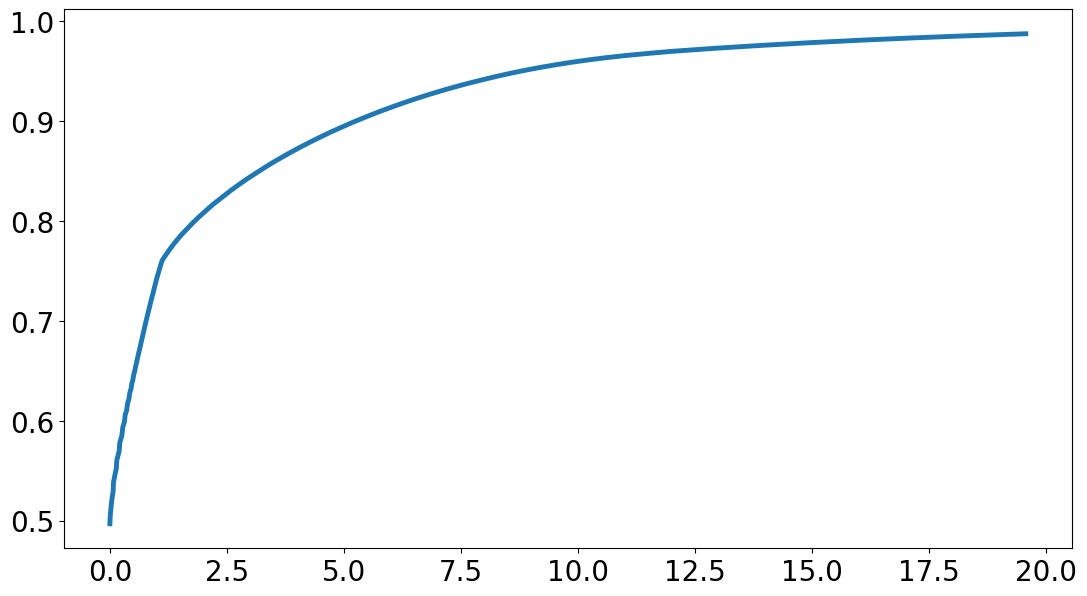

In [32]:
plt.plot(a_grid[:300], D.sum(axis=0).cumsum()[:300]);

# Visualizing steady-state distribution
- Better to plot up to a much lower level of assets, e.g. up to $a=20$
    * (20x average quarterly income; 5x average annual income)
    
    
- Only small fraction has assets above $a=20$ (but they will turn out to hold a lot of assets!); half hold nothing at all

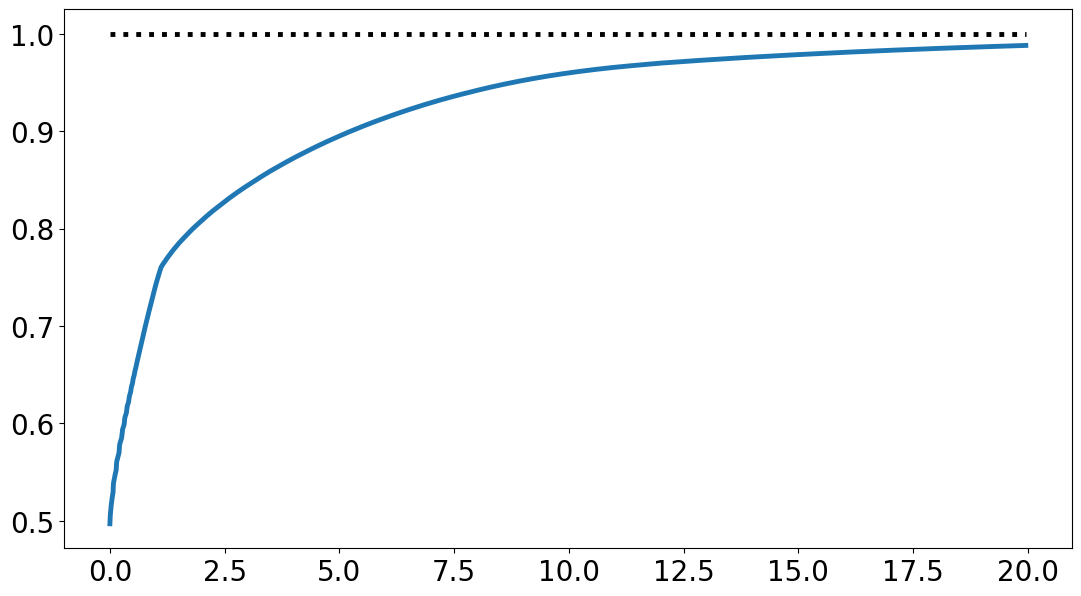

In [33]:
i = np.argmax(a_grid > 20) # first gridpoint above 20
plt.plot(a_grid[:i], D.sum(axis=0)[:i].cumsum())
plt.hlines(1,0, a_grid[i-1], colors='k', linestyles='dotted');

# Visualizing steady-state distribution, continued
- Zoom in further, up to $a=2$


- Start to see some interesting features
    * Jumps in CDF near zero that look like mass points of distribution
    * Kink just above 1 that looks like a sudden drop in density

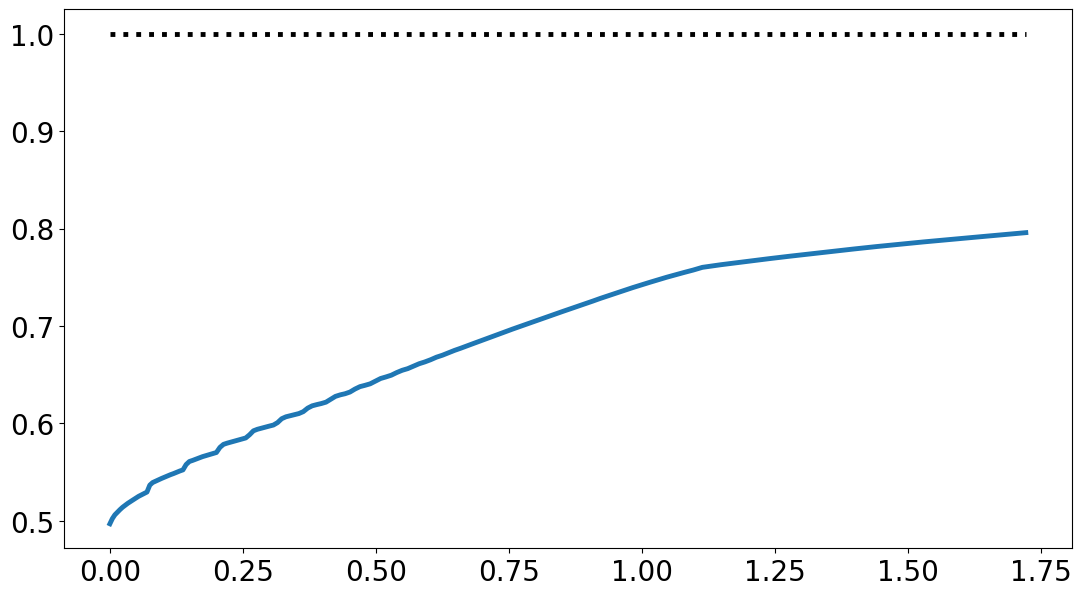

In [34]:
i = np.argmax(a_grid > 2) # first gridpoint above 2
plt.plot(a_grid[:150], D.sum(axis=0)[:150].cumsum())
plt.hlines(1,0, a_grid[149], colors='k', linestyles='dotted');

# Visualizing steady-state distribution
- Plot CDF separately by income state, highly right-skewed in upper states, interesting behavior mostly in $y=1.39$ middle state


- Why? Common occurences with discrete time and discrete states:
    * Mass point at $a=0$ for $y < 1.39$ leads to mass points above 0, as households whose income has increased to $y=1.39$ save for one, two, three, ... periods 
    * Target assets for $y=1.39$ is slightly above 1; $y=1.39$ households converge to this level from both sides but don't cross, more converge from below so density discontinuous

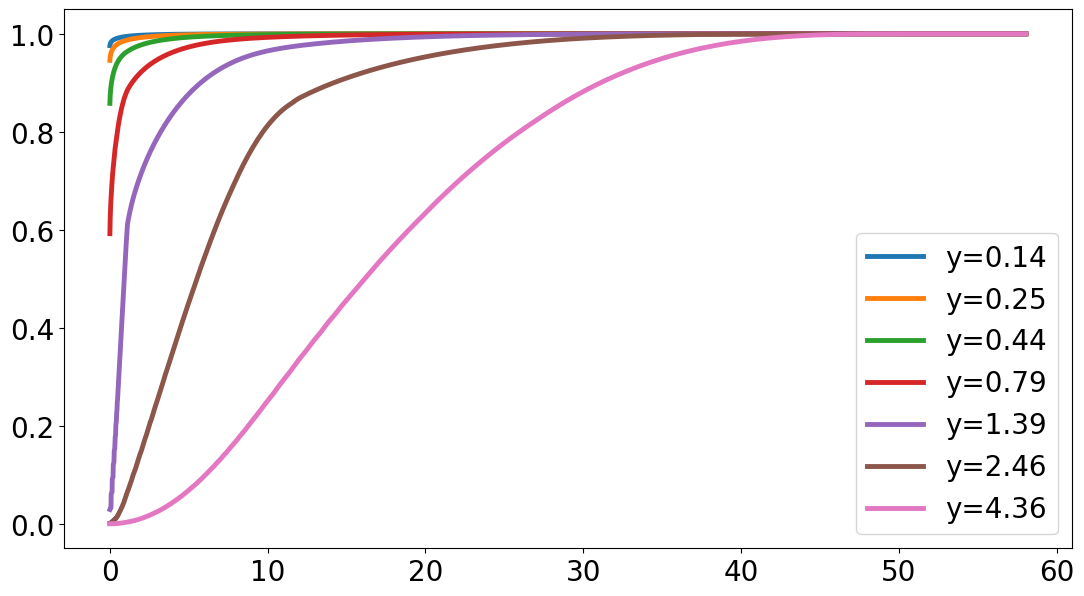

In [35]:
for e, ye in enumerate(y):
    plt.plot(a_grid[:350], D[e][:350].cumsum()/pi[e], label=f'y={ye:.2f}')
plt.legend();

# How many assets held in each state?
Let's get a sense of extent to which higher incomes hold far higher assets, even relative to income:

In [36]:
for e, ye in enumerate(y):
    print(f'Total Asset at y={ye:.2f}: {np.vdot(a_grid, D[e, :]):.2f}')
    print(f'Average Asset at y={ye:.2f}: {np.vdot(a_grid, D[e, :]) / pi[e]:.2f}')

Total Asset at y=0.14: 0.00
Average Asset at y=0.14: 0.02
Total Asset at y=0.25: 0.00
Average Asset at y=0.25: 0.05
Total Asset at y=0.44: 0.04
Average Asset at y=0.44: 0.16
Total Asset at y=0.79: 0.17
Average Asset at y=0.79: 0.56
Total Asset at y=1.39: 0.51
Average Asset at y=1.39: 2.19
Total Asset at y=2.46: 0.66
Average Asset at y=2.46: 7.01
Total Asset at y=4.36: 0.28
Average Asset at y=4.36: 17.67


In [37]:
for e, ye in enumerate(y):
    print(f'Total Consumption at y={ye:.2f}: {np.vdot(c[e,:], D[e, :]):.2f}')
    print(f'Average Consumption at y={ye:.2f}: {np.vdot(c[e,:], D[e, :]) / pi[e]:.2f}')

Total Consumption at y=0.14: 0.00
Average Consumption at y=0.14: 0.14
Total Consumption at y=0.25: 0.02
Average Consumption at y=0.25: 0.26
Total Consumption at y=0.44: 0.11
Average Consumption at y=0.44: 0.46
Total Consumption at y=0.79: 0.26
Average Consumption at y=0.79: 0.83
Total Consumption at y=1.39: 0.34
Average Consumption at y=1.39: 1.44
Total Consumption at y=2.46: 0.22
Average Consumption at y=2.46: 2.31
Total Consumption at y=4.36: 0.06
Average Consumption at y=4.36: 3.57


In [38]:
avg_asset = np.zeros_like(y)
total_asset = np.zeros_like(y)
for e in range(7):
    total_asset[e] = np.vdot(a_grid, D[e, :])
    avg_asset[e] = np.vdot(a_grid, D[e, :]) / pi[e]

avg_cons = np.zeros_like(y)
total_cons = np.zeros_like(y)
for e in range(7):
    total_cons[e] = np.vdot(c[e,:], D[e, :])
    avg_cons[e] = np.vdot(c[e,:], D[e, :]) / pi[e]

### Average and Total Asset for each income group:

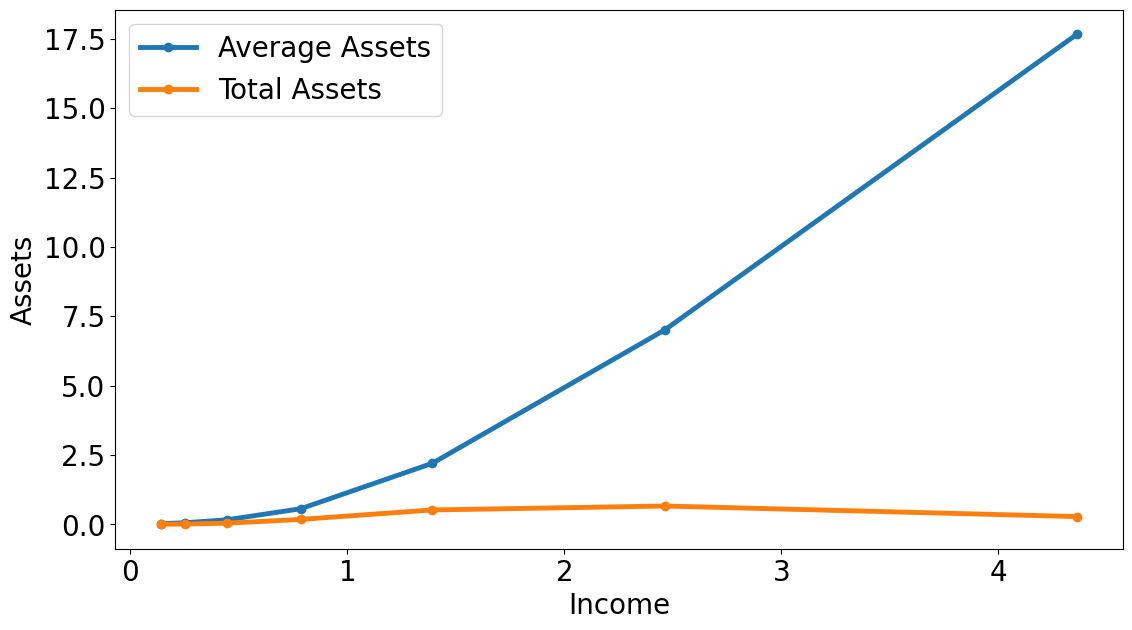

In [39]:
plt.plot(y, avg_asset, label='Average Assets', marker = 'o')
plt.plot(y, total_asset, label='Total Assets', marker = 'o')
plt.legend()
plt.xlabel('Income')
plt.ylabel('Assets')
plt.show()

### Average and Total consumption for each income group:

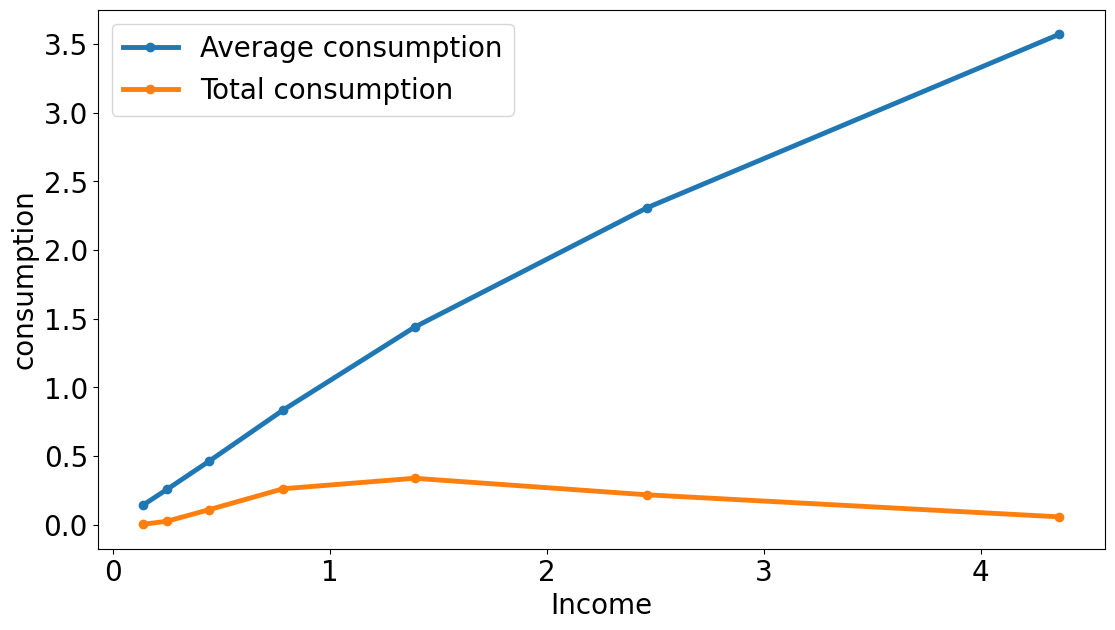

In [40]:
plt.plot(y, avg_cons, label='Average consumption', marker = 'o')
plt.plot(y, total_cons, label='Total consumption', marker = 'o')
plt.legend()
plt.xlabel('Income')
plt.ylabel('consumption')
plt.show()

### Share of each income group from total population

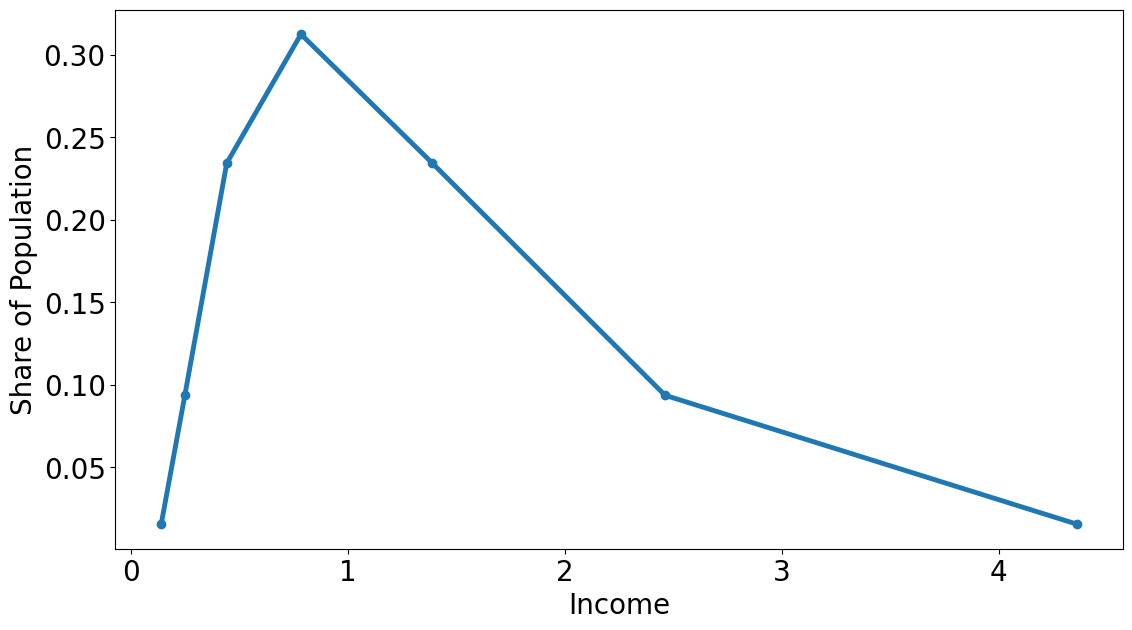

In [41]:
plt.plot(y, pi, marker = 'o')
plt.xlabel('Income')
plt.ylabel('Share of Population')
plt.show()

# What fraction of assets held in each state?
Higher income states hold a lot more, but rarer. Still, top few hold most assets:

In [42]:
for e, ye in enumerate(y):
    print(f'Total assets at y={ye:.2f} ({100*pi[e]:.1f}% of hh)\t: {np.vdot(a_grid, D[e, :]):.2f}')

Total assets at y=0.14 (1.6% of hh)	: 0.00
Total assets at y=0.25 (9.4% of hh)	: 0.00
Total assets at y=0.44 (23.4% of hh)	: 0.04
Total assets at y=0.79 (31.2% of hh)	: 0.17
Total assets at y=1.39 (23.4% of hh)	: 0.51
Total assets at y=2.46 (9.4% of hh)	: 0.66
Total assets at y=4.36 (1.6% of hh)	: 0.28


Sum of these is total assets held in economy:

In [43]:
np.sum(a_grid*D) # use array broadcasting since a_grid missing 'e' dimension

1.6645070676480889

which should equal (up to numerical error) total assets chosen for tomorrow:

In [44]:
np.vdot(a, D)

1.664507066193902

# Part 4 of computation: aggregating to full steady state
- Simplest part: combine parts 2 and 3 and aggregate to get total consumption and assets in one big function


- Return a dict with all inputs to the problem (`Pi`, `a_grid`, `y`, `r`, `beta`, `eis`), the individual level policies and marginal value function (`a`, `c`, `Va`), the distribution (`D`), and aggregate policies (`A` and `C`)

In [45]:
def steady_state(Pi, a_grid, y, r, beta, eis):
    Va, a, c = policy_ss(Pi, a_grid, y, r, beta, eis)
    D = distribution_ss(Pi, a, a_grid)
    
    return dict(D=D, Va=Va, 
                a=a, c=c,
                A=np.vdot(a, D), C=np.vdot(c, D), # aggregation
                Pi=Pi, a_grid=a_grid, y=y, r=r, beta=beta, eis=eis)

In [46]:
ss = steady_state(Pi, a_grid, y, r, beta, eis)
ss.keys()

dict_keys(['D', 'Va', 'a', 'c', 'A', 'C', 'Pi', 'a_grid', 'y', 'r', 'beta', 'eis'])

# Application: comparative statics in $r$
Steady-state assets slope sharply upward as we increase the steady-state real interest rate $r$, and indeed asymptote to infinity as we approach $r=\beta^{-1}-1$, which in this case is just above 0.02:

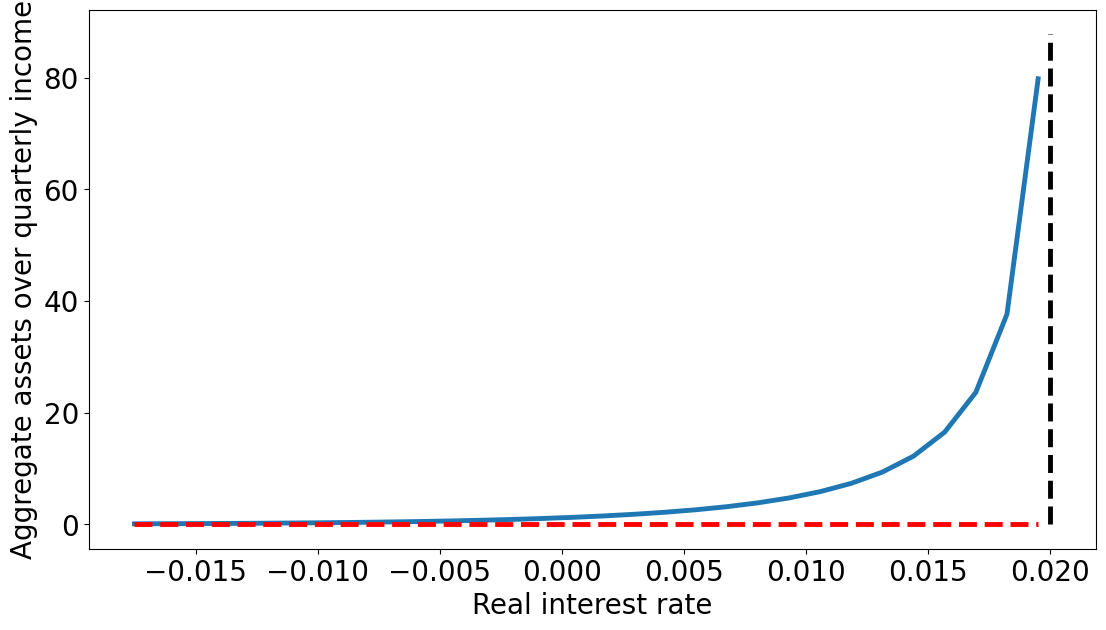

In [47]:
rs = r + np.linspace(-0.02, 0.017, 30)
As = [steady_state(Pi, a_grid, y, r, beta, eis)['A'] for r in rs]
plt.plot(rs, As)
plt.vlines(0.02, 0, 1.1*max(As), linestyle='--', color='k')
plt.hlines(0, rs[0], rs[-1], linestyle='--', color='r')
plt.xlabel('Real interest rate')
plt.ylabel('Aggregate assets over quarterly income');

### Note: 
Higher interest rate means higher incentive to save. Thus, higher aggregate asset is reached.

# Application: comparative statics in income risk

Steady-state assets also slope strongly upward in income risk, which we'll manipulate below by calibrating to different standard deviations $\sigma$ of cross-sectional log income. (This turns out to change only the vector `y` of incomes, making them more dispersed, not the Markov matrix `Pi`.)

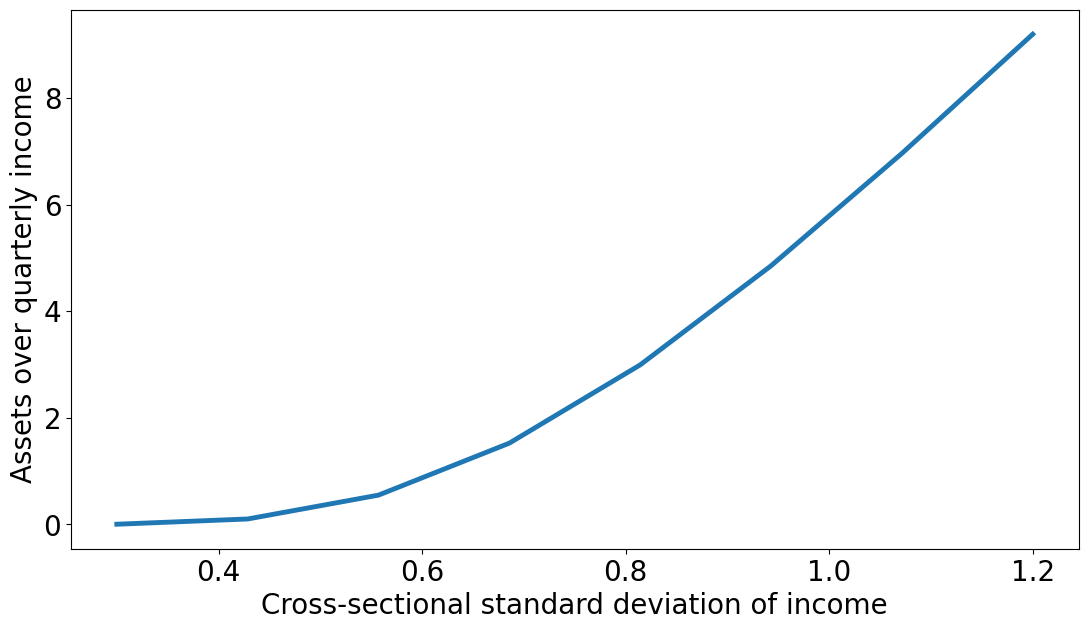

In [48]:
sigmas = np.linspace(0.3, 1.2, 8) # our benchmark was sigma=0.7
As = []
for sigma in sigmas:
    y_new, pi_new, Pi_new = discretize_income(0.975, sigma, 7)
    As.append(steady_state(Pi_new, a_grid, y_new, r, beta, eis)['A'])
plt.plot(sigmas, As)
plt.xlabel('Cross-sectional standard deviation of income')
plt.ylabel('Assets over quarterly income');

### Note:
Higher income risk means higher incentive for precautionary saving. Therefore, a higher level of aggregate asset is reached.

# Application: comparative statistics in intertemporal substitution

- Steady-state assets are also decreasing in the elasticity of intertemporal substitution, or equivalently increasing in the coefficient of risk aversion (its inverse)


- This is because with lower risk aversion and less desire to smooth consumption, the precautionary and income-smoothing motives for saving become weaker

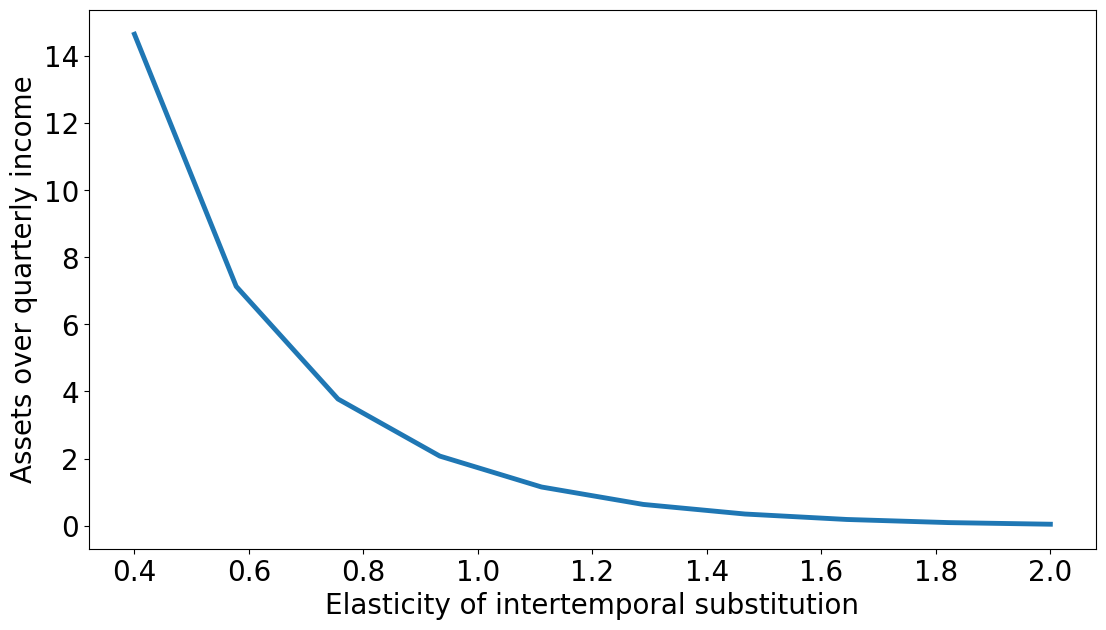

In [49]:
eis_vec = np.linspace(0.4, 2, 10) # our benchmark was eis=1
As = [steady_state(Pi, a_grid, y, r, beta, eis)['A'] for eis in eis_vec]
plt.plot(eis_vec, As)
plt.xlabel('Elasticity of intertemporal substitution')
plt.ylabel('Assets over quarterly income');

### Note:

Higher eis means lower relative risk aversion. Therefore, given everything constant, the incentive for precautionary saving will decline. So, lower levels of aggregate asset is reached.

# What remains?
- We've learned how to compute the full steady state—including the steady state policy functions, the steady state distribution, and aggregates—of the standard incomplete markets model


- Remaining topics to briefly cover
    * **Calibration:** choosing some parameters to hit steady-state calibration targets, rather than exogenously specifying all parameters
    * **General equilibrium:** how to think about the SIM as part of a very simple general equilibrium model
    * **Expectation functions:** a tool to compute almost any desired moment of individual behavior, which will also come in handy later as part of the fake news algorithm (sometimes called *expectation vectors*)

# Calibration
- Suppose we want to choose total assets to equal a certain level relative to income
    * say, 140% of annual household income (inspired by [McKay, Nakamura, and Steinsson](https://eml.berkeley.edu/~enakamura/papers/forwardguidance.pdf), who calibrate to 140% of annual GDP)
    * average quarterly income normalized to 1, so with this target `A` must be $4\times 1.4=5.6$
    * calibrate all other parameters directly, choose discount factor $\beta$ to hit this target
    * for one-dimensional root-finding use the robust and quick Brent's method

In [55]:
beta_calib = optimize.brentq(
                lambda beta: steady_state(Pi, a_grid, y, r, beta, eis)['A'] - 5.6,
                0.98, 0.995)
beta_calib

0.987703940322874

Get entire steady state and verify we have right assets:

In [51]:
ss_calib = steady_state(Pi, a_grid, y, r, beta_calib, eis)
ss_calib['A'], ss_calib['C']

(5.599999999969411, 1.0140000048859803)

Check aggregate steady-state budget balance $C=1+rA$ (up to numerical error from our steady-state tolerance):

$$
c+a' = (1+r)a + y(e) \rightarrow C + A = (1+r)A + E[y] \rightarrow C = 1+rA
$$

In [52]:
ss_calib['C'] - (1 + ss_calib['r']*ss_calib['A'])

4.886056670372341e-09

# General equilibrium
- So far we just discussed the household problem in isolation ("partial equilibrium")



- How to think about GE?
    * Suppose households have stochastic endowments $e$ of effective labor (average of 1), following same Markov process that $y(e)$ previously did
    * Each unit produces one unit of consumption goods in a perfectly competitive production sector, so real wage is 1
    * Households save in government bonds, paying real interest rate $r$ and supplied in exogenous quantity $B$
    * Government finances this with tax $\tau = rB$ on labor, households' after-tax labor income is $y(e)=(1-\tau)e$
    
    

- **Only difference here from before** is that $y(e)$ in households' budget constraint includes factor of $1-\tau$

# General equilibrium calibration
Calibrate similar to before:

In [56]:
B = 5.6   # annual bonds/GDP is 140%, so quarterly is 560%, and quarterly GDP is 1
tau = r*B # labor tax needed to balance steady-state government budget
e = y     # use our previous y, which had mean 1, for the labor endowment process

Because of the low real interest rate, $\tau$ is quite small:

In [57]:
tau

0.013999999999999999

Now calibrate $\beta$ to be consistent with steady-state asset market clearing $A=B$, using $(1-\tau)e$ as income:

In [58]:
beta_ge = optimize.brentq(
                lambda beta: steady_state(Pi, a_grid, (1-tau)*e, r, beta, eis)['A'] - B,
                0.98, 0.995)
beta_ge

0.9877855433151485

Compute full steady state with `beta_ge`, check asset market and goods market clearing:

In [59]:
ss_ge = steady_state(Pi, a_grid, (1-tau)*e, r, beta_ge, eis)
ss_ge['A'] - B, ss_ge['C'] - 1 # asset mkt clearing, goods mkt clearing

(-1.6628476373625745e-11, 4.7859176621756205e-09)

# General equilibrium counterfactuals
- Now that we have full calibrated GE model, can do GE comparative statics
    * Vary some parameter and re-solve for GE real interest rate $r$, keeping all other parameters constant
    

- Example: vary income risk like before
    * Now total assets are fixed and can't change, but $r$ falls to equilibriate the market as risk rises and households want to save more
    * (Note this computation is a little slow, since we are looping over $\sigma$ and solving separately for each $r$. Smarter ways exist to do this, which we won't cover now.)

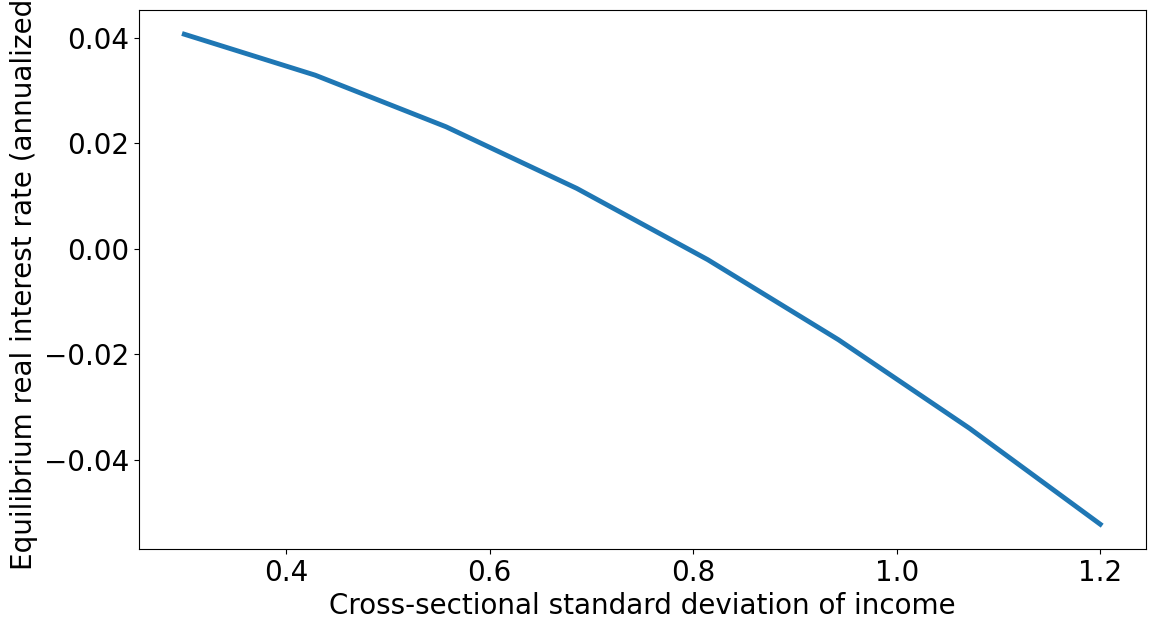

In [60]:
sigmas = np.linspace(0.3, 1.2, 8) # our benchmark was sigma=0.7
rs = []
for sigma in sigmas:
    e_new, pi_new, Pi_new = discretize_income(0.975, sigma, 7)
    rs.append(optimize.brentq(
                lambda r: steady_state(Pi_new, a_grid, (1-r*B)*e_new, r, beta_ge, eis)['A'] - B,
                -0.02, 0.015))
plt.plot(sigmas, 4*np.array(rs))
plt.xlabel('Cross-sectional standard deviation of income')
plt.ylabel('Equilibrium real interest rate (annualized)');

### Note: 
Higher income risk means higher incentive for precautionary saving. Therefore, the interest rate should fall for clearing the asset market.

# Expectation functions
- Suppose we have some function $x(e,a)$ of the state
 

- If the state for an individual household is $(e_t,a_t)$ today, what do we expect $x(e_{t+j},a_{t+j})$ to be, assuming household follows steady-state policy rule?


- Call this the $j$th **expectation function** $\mathcal{E}_j$:

$$
\mathcal{E}_j(e,a) \equiv \mathbb{E}[x(e_{t+j}, a_{t+j}) | (e_t, a_t)]
$$
    

- Insight: **law of iterated expectations** implies a simple recursion with base case $\mathcal{E}_0(e,a) = x(e,a)$:

$$
\mathcal{E}_j(e,a) = \mathbb{E}[\mathcal{E}_{j-1}(e',a') | (e,a)] \tag{15}
$$


- So as long as we know how to calculate **one-period-ahead expectations** to evaluate right side of (15), we can calculate expectation functions at any horizon!
    - This will enable us to do a lot!
    - We'll turn to one-period-ahead expectations now...

# Part one of one-period-ahead expectations: take expectations with respect to lottery
Recall that given `a_i` and `a_pi` describing the lottery form of policy, we updated the beginning-of-period distribution $D_t(e,a)$ to an end-of-period distribution $D_t^{end}(e, a')$ using:

In [71]:
@numba.njit
def forward_policy(D, a_i, a_pi):
    Dend = np.zeros_like(D)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # send pi(e,a) of the mass to gridpoint i(e,a)
            Dend[e, a_i[e,a]] += a_pi[e,a]*D[e,a]
            
            # send 1-pi(e,a) of the mass to gridpoint i(e,a)+1
            Dend[e, a_i[e,a]+1] += (1-a_pi[e,a])*D[e,a]
            
    return Dend

Here, we need to go in the **opposite direction**: start with some end-of-period variable $X_t^{end}(e,a')$, and obtain its beginning-of-period expectation $X_t(e,a) = \pi(e,a)*X_t^{end}(e,i(e,a)) + (1-\pi(e,a))*X_t^{end}(e,i(e,a)+1)$. Though we don't write it explicitly as a matrix, one can verify that this is actually the *transpose* of the linear mapping in `forward_policy`:

In [72]:
@numba.njit
def expectation_policy(Xend, a_i, a_pi):
    X = np.zeros_like(Xend)
    for e in range(a_i.shape[0]):
        for a in range(a_i.shape[1]):
            # expectation is pi(e,a)*Xend(e,i(e,a)) + (1-pi(e,a))*Xend(e,i(e,a)+1)
            X[e, a] = a_pi[e, a]*Xend[e, a_i[e, a]] + (1-a_pi[e, a])*Xend[e, a_i[e, a]+1]
            
    return X

# Combine with taking expectations over the state
Recall that for the distribution, we updated $D_t^{end}(e,a')$ to $D_{t+1}^{end}(e',a')$ by multiplying by the transpose of the Markov matrix, then combined this with the update using the lottery:

In [53]:
def forward_iteration(D, Pi, a_i, a_pi):
    Dend = forward_policy(D, a_i, a_pi)    
    return Pi.T @ Dend

Similarly, here we need to obtain $X_t^{end}(e,a') = \mathbb{E}_t[X_{t+1}(e',a') | e]$ by taking expectations with respect to $e'$, then combine this with the code we already wrote to obtain $X_t(e,a)$ from $X_t^{end}(e,a')$:

In [73]:
def expectation_iteration(X, Pi, a_i, a_pi):
    Xend = Pi @ X
    return expectation_policy(Xend, a_i, a_pi)

Note that taking expectations goes in the opposite order (first take expectations with respect to $s'$, then $a'$) as updating the distribution, because it's going backward in time rather than forward.

# Obtaining expectation functions
- Write a simple function that takes in any function $x(e,a)$ of the state (in the form of an $n_e\times n_a$ array `X`) and calculates expectation functions$\mathcal{E}_0,\ldots,\mathcal{E}_{T-1}$ up to some horizon $T$.


- Use recursion based on law of iterated expectations:

$$
\mathcal{E}_j(e,a) = \mathbb{E}[\mathcal{E}_{j-1}(e',a') | (e,a)] \tag{15}
$$

- Combined with base case $\mathcal{E}_0(e,a) \equiv x(e,a)$, just repeatedly apply `expectation_iteration` to evaluate right side of (15):

In [74]:
def expectation_functions(X, Pi, a_i, a_pi, T):
    # set up array of curlyEs and fill in first row with base case
    curlyE = np.empty((T, ) + X.shape)
    curlyE[0] = X
    
    # recursively apply law of iterated expectations
    for j in range(1, T):
        curlyE[j] = expectation_iteration(curlyE[j-1], Pi, a_i, a_pi)
        
    return curlyE

# Application: autocorrelation of consumption
- Want to calculate correlation between individual consumption at dates $t$ and $t+j$ in steady state


- To do this first get covariances (where $\tilde{c}(e,a)\equiv c(e,a) - C$ is demeaned consumption and $\mathcal{E}_j^{\tilde{c}}$ are expectation functions of $\tilde{c}$):

$$
\begin{align}
\text{Cov}(c(e_t,a_t), c(e_{t+j},a_{t+j}))
&= \mathbb{E}[\tilde{c}(e_t,a_t)\cdot \tilde{c}(e_{t+j},a_{t+j})] \\
&= \mathbb{E}[\tilde{c}(e_t,a_t) \cdot \mathbb{E}[\tilde{c}(e_{t+j},a_{t+j}) | (e_t,a_t)]] \\
&= \mathbb{E}[\tilde{c}(e_t,a_t) \cdot \mathcal{E}_j^{\tilde{c}}(e_t,a_t)]
\end{align}
$$


- In other words, we just need to evaluate the product of $\tilde{c}$ and its $j$-period-ahead expectation $\mathcal{E}_j^{\tilde{c}}$ at all $(e,a)$, then aggregate across distribution
    * Implement on next slide!

# Application: autocorrelation of consumption, continued
Let's try this for all $j$ up to $T=40$:

In [75]:
T = 40
ctilde = c - np.vdot(D, c) # demeaned consumption
E_ctilde = expectation_functions(ctilde, Pi, a_i, a_pi, T) # expectation functions for 0, ... , T-1

Need to take product of `ctilde` with the $j$th row of `E_ctilde`, then aggregate by steady-state distribution `D`.

In [76]:
Autocov_c = np.empty(T)
for j in range(T):
    Autocov_c[j] = np.vdot(D, ctilde * E_ctilde[j])

Autocorrelation is autocovariance divided by variance, and variance is autocovariance at a lag of zero, so can write:

In [77]:
Autocorr_c = Autocov_c / Autocov_c[0]

*Python trickery side note:* not necessary here for speed, but can calculate `Autocov_c` above without a `for` loop by flattening state space $(e,a)$ into one dimension using `ravel` (for `ctilde*D`) and `reshape` (for `E_ctilde`) and then doing matrix multiplication:

In [78]:
Autocov_c_alt = E_ctilde.reshape((T, -1)) @ (ctilde*D).ravel()
assert np.max(np.abs(Autocov_c_alt - Autocov_c)) < 1E-15 # verify this is right

# Application: autocorrelation of consumption, visualized

- **Applaud ourselves for calculating this exactly, and almost instantly, without any Monte Carlo simulation!**


- Consumption pretty persistent here, reflecting both persistence in underlying income process and smoothing via assets


- But maybe not persistent enough? Empirically, population-level correlation between $c_t$ and $c_{t+j}$ probably above .50 even at 10-year horizon (unmodeled permanent component of income?)

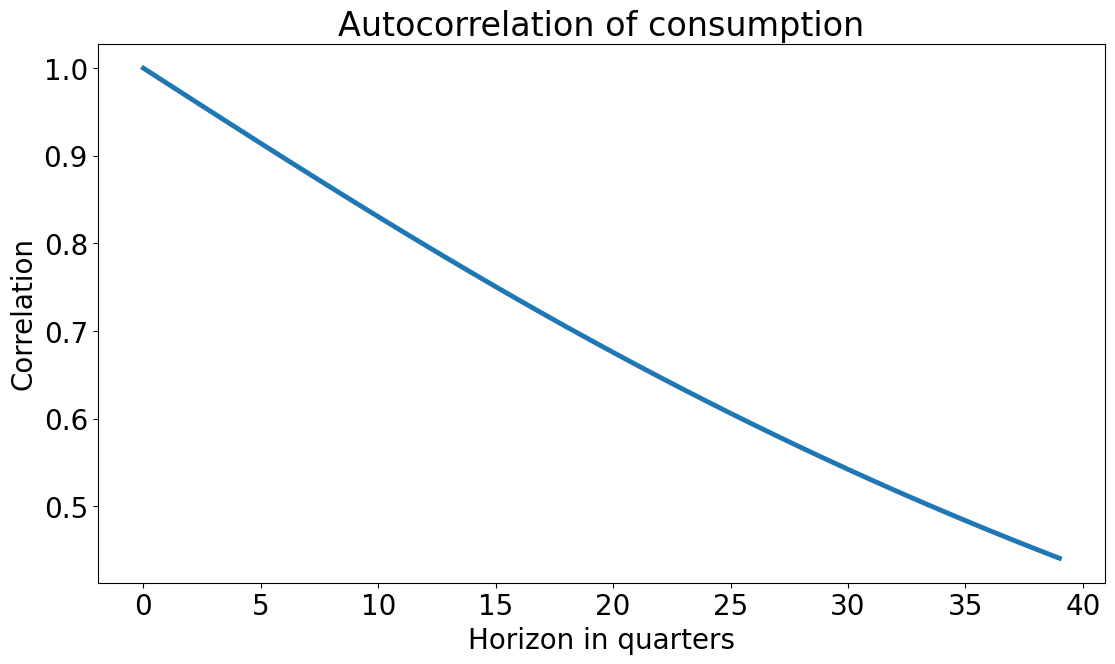

In [79]:
plt.plot(Autocorr_c)
plt.title('Autocorrelation of consumption')
plt.xlabel('Horizon in quarters')
plt.ylabel('Correlation');